In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    IsolationForest,
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
)

In [27]:
df = pd.read_csv('celldata.csv')
print(df.head())
print(df.info())
print(df.describe())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          632   Germany  Female   50       5  107959.39              1   
1          649    France  Female   42       7       0.00              2   
2          595    France    Male   29       6  150685.79              1   
3          653     Spain    Male   35       6  116662.96              2   
4          559     Spain  Female   40       7  144470.77              1   

   HasCrCard  IsActiveMember  Salary  Churn  
0          1               1    6985      1  
1          0               1   22974      0  
2          1               0   87771      0  
3          1               1   23864      0  
4          1               1   18918      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     8000 non-null   int64  
 1   Geography       8000 non-n

In [28]:
print(df.describe().loc[['min', 'max']])
print(df.isnull().sum())

print(df['Geography'].unique())
print(df['Gender'].unique())

     CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
min        350.0  18.0     0.0       0.00            1.0        0.0   
max        850.0  92.0    10.0  250898.09            4.0        1.0   

     IsActiveMember    Salary  Churn  
min             0.0      12.0    0.0  
max             1.0  199992.0    1.0  
CreditScore       0
Geography         0
Gender            0
Age               0
Tenure            0
Balance           0
NumOfProducts     0
HasCrCard         0
IsActiveMember    0
Salary            0
Churn             0
dtype: int64
['Germany' 'France' 'Spain']
['Female' 'Male']


In [29]:
y = df['Churn']
X = df.drop(columns=['Churn'])
X['Gender'] = X['Gender'].map({'Female': 0, 'Male': 1})
X = pd.get_dummies(X, columns=['Geography'], drop_first=True)
print(X.head())
print(X.info())
print(y.value_counts())

   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          632       0   50       5  107959.39              1          1   
1          649       0   42       7       0.00              2          0   
2          595       1   29       6  150685.79              1          1   
3          653       1   35       6  116662.96              2          1   
4          559       0   40       7  144470.77              1          1   

   IsActiveMember  Salary  Geography_Germany  Geography_Spain  
0               1    6985               True            False  
1               1   22974              False            False  
2               0   87771              False            False  
3               1   23864              False             True  
4               1   18918              False             True  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
--- 

In [30]:
# Anomaly Detection on customer base
# We use two unsupervised methods:
# - Isolation Forest (global anomalies)
# - Local Outlier Factor (local anomalies)

# We use all preprocessed features X (numeric Gender + Geography dummies)
# and do separate scaling for anomaly detection methods
scaler_anom = StandardScaler()
X_anom_scaled = scaler_anom.fit_transform(X)

# %%
# === 1) Isolation Forest ===
iso = IsolationForest(
    n_estimators=200,
    contamination='auto',   # let the model choose the fraction of anomalies
    random_state=42
)

iso.fit(X_anom_scaled)

# score_samples: lower values => more anomalous
iso_raw_scores = iso.score_samples(X_anom_scaled)
iso_scores = -iso_raw_scores  # invert the sign: higher = more anomalous

# We can define anomalies as the top 5% most anomalous points (you can change the percentage)
threshold_iso = np.percentile(iso_scores, 95)
iso_anomaly_flag = (iso_scores >= threshold_iso).astype(int)

print(f"Isolation Forest - % points marked as anomalies (top 5%): {iso_anomaly_flag.mean()*100:.2f}%")
# %%
# === 2) Local Outlier Factor (LOF) ===
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05,  # also here ~5% expected anomalies
    novelty=False        # classic mode: fit_predict on the entire dataset
)

lof_labels = lof.fit_predict(X_anom_scaled)   # -1 = outlier, 1 = inlier
lof_anomaly_flag = (lof_labels == -1).astype(int)

print(f"LOF - % points marked as anomalies: {lof_anomaly_flag.mean()*100:.2f}%")

# We add the results to the original dataframe
df_anom = df.copy()
df_anom['iso_score'] = iso_scores
df_anom['iso_anomaly'] = iso_anomaly_flag
df_anom['lof_anomaly'] = lof_anomaly_flag

df_anom.head()


Isolation Forest - % points marked as anomalies (top 5%): 5.00%
LOF - % points marked as anomalies: 5.00%


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Churn,iso_score,iso_anomaly,lof_anomaly
0,632,Germany,Female,50,5,107959.39,1,1,1,6985,1,0.518909,0,0
1,649,France,Female,42,7,0.00,2,0,1,22974,0,0.512404,0,0
2,595,France,Male,29,6,150685.79,1,1,0,87771,0,0.467266,0,0
3,653,Spain,Male,35,6,116662.96,2,1,1,23864,0,0.501032,0,0
4,559,Spain,Female,40,7,144470.77,1,1,1,18918,0,0.525828,0,0


In [31]:
# Comparison of churn rate between anomalies and non-anomalies

for col in ['iso_anomaly', 'lof_anomaly']:
    print(f"\n=== {col} ===")
    print(df_anom.groupby(col)['Churn'].agg(['mean', 'count']))



=== iso_anomaly ===
                 mean  count
iso_anomaly                 
0            0.184868   7600
1            0.510000    400

=== lof_anomaly ===
                 mean  count
lof_anomaly                 
0            0.183421   7600
1            0.537500    400


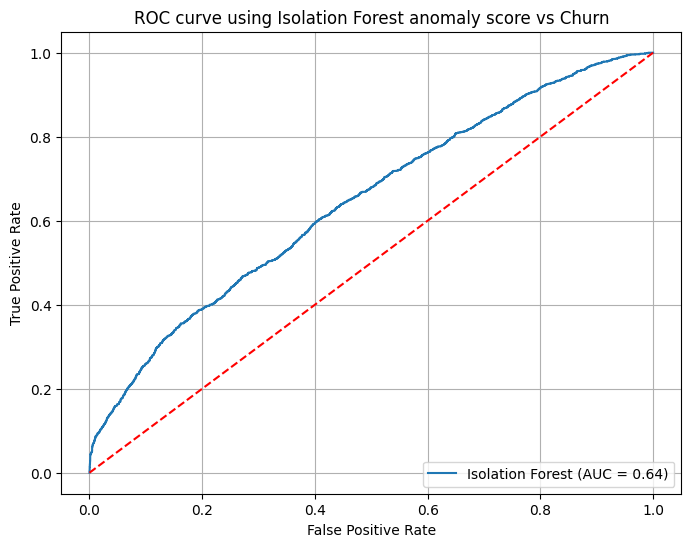

In [32]:
# Isolation Forest: ROC with anomaly score
fpr_iso, tpr_iso, _ = roc_curve(y, iso_scores)
roc_auc_iso = auc(fpr_iso, tpr_iso)

plt.figure(figsize=(8,6))
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {roc_auc_iso:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve using Isolation Forest anomaly score vs Churn')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Interpretation of Anomaly Detection Results
ROC Curve Interpretation (AUC ≈ 0.64)
The ROC curve obtained using the Isolation Forest anomaly score yields an AUC of approximately 0.64. Since an AUC of 0.5 corresponds to random guessing, any value above 0.5 indicates that customers with higher anomaly scores are more likely to churn than those with lower anomaly scores. This means the anomaly score contains useful predictive information about churn, even though it is not a strong standalone classifier.

Percentage of Detected Anomalies
Both Isolation Forest and LOF (Local Outlier Factor) identify approximately 5% of customers as anomalies. This reflects the contamination level or threshold chosen, but the meaningful part is how these anomalous customers behave with respect to churn.

Churn Rate Among Anomalies vs Non-Anomalies
Isolation Forest:
Normal customers: churn rate ≈ 18%
Anomalous customers: churn rate ≈ 51%
LOF:
Normal customers: churn rate ≈ 18%
Anomalous customers: churn rate ≈ 54%
These results show clearly that anomalous customers churn almost three times more often than normal customers. Both methods independently identify the same phenomenon, which strongly validates the conclusion.
From a business perspective, anomalous customers represent a high-risk segment, and their unusual behavior is linked to significantly higher churn probability.

Should Anomalies Be Removed?
No, anomalies should not be removed.
Reasons:
Anomalies are not noise or errors. They represent high-risk customers whose behavior deviates from the usual patterns.
Removing anomalies would remove exactly the customers who are most likely to churn. This would eliminate the strongest predictive signal in the dataset.
The goal is churn prediction, not data cleaning. Removing these customers would make the model less realistic and less effective in real business scenarios.
In this context, anomaly detection reveals structure in the data, not mistakes.
What Should Be Done Instead?
Instead of removing anomalies, the anomaly flags (iso_anomaly and lof_anomaly) should be added as new input features for the supervised models. These features typically improve model performance because they highlight customers with unusual or risky behavior.
By including these signals, the models can better distinguish between stable and at-risk clients.

In [33]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

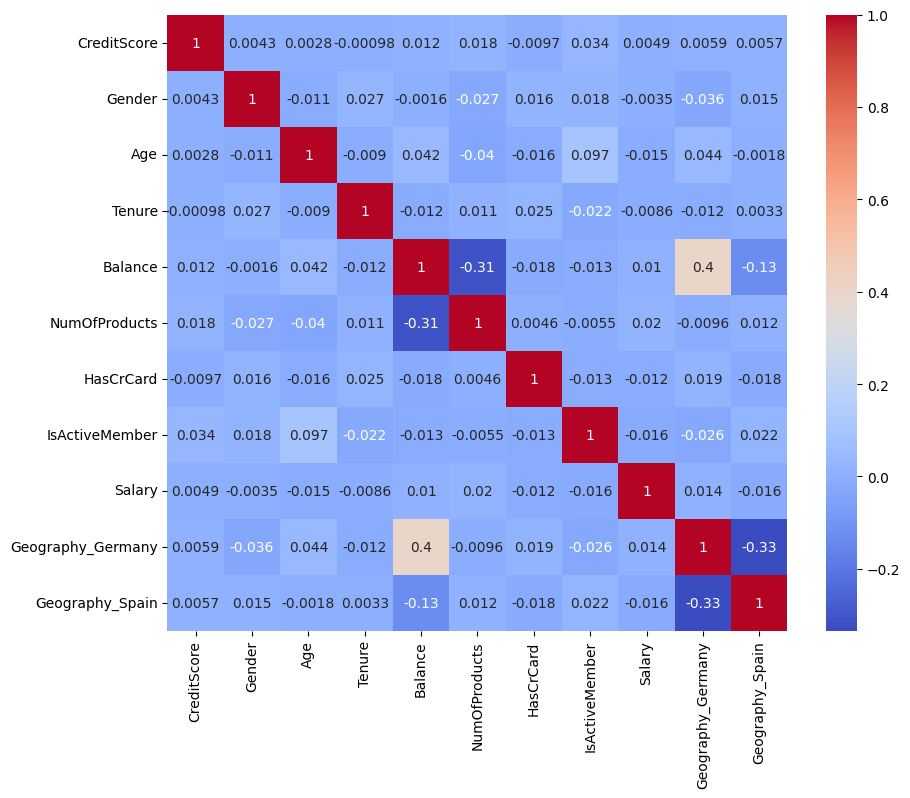

In [34]:
corr = X_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

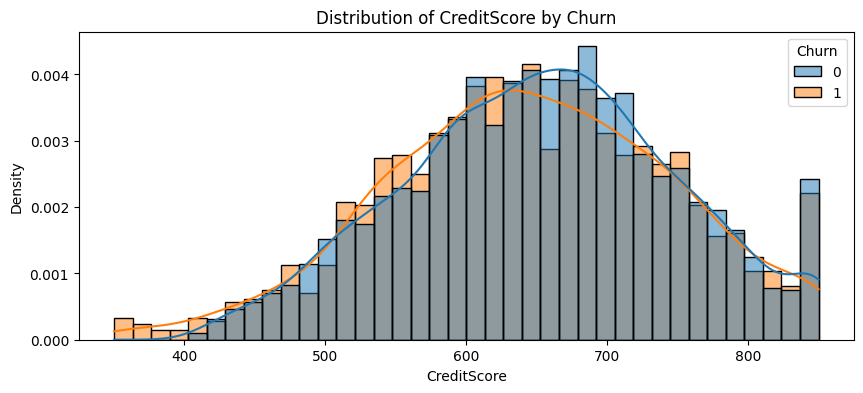

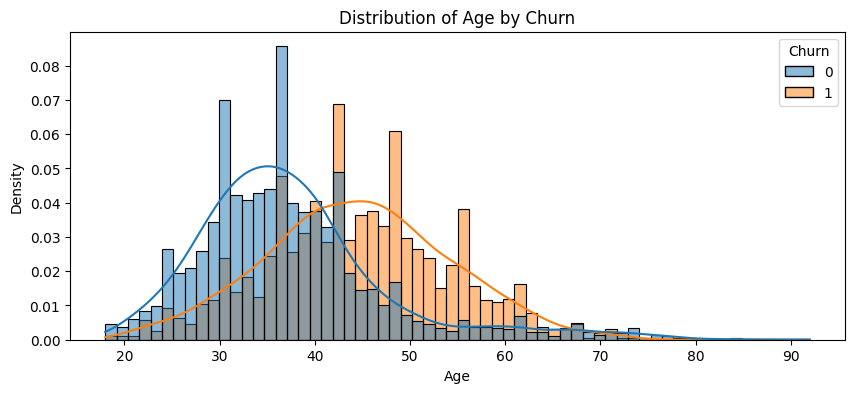

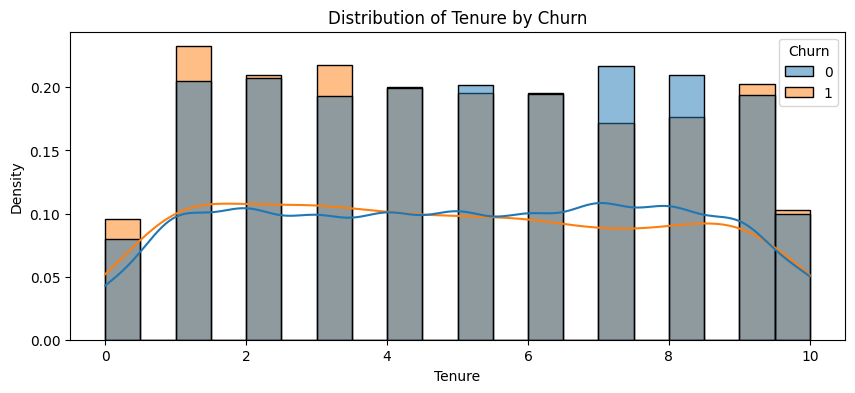

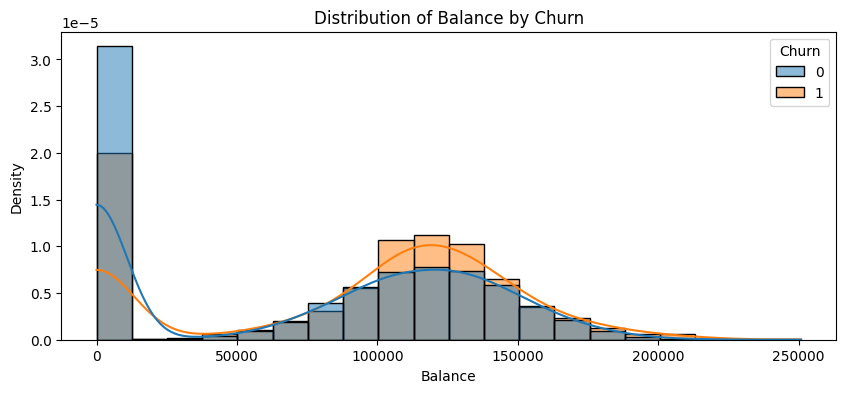

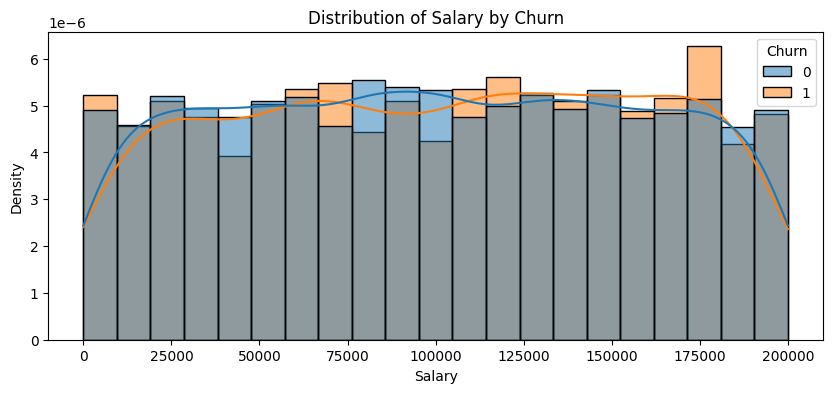

In [35]:
for col in ['CreditScore', 'Age', 'Tenure', 'Balance', 'Salary']:
    plt.figure(figsize=(10,4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, stat='density', common_norm=False)
    plt.title(f'Distribution of {col} by Churn')
    plt.show()

Accuracy: 0.7925
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1278
           1       0.40      0.06      0.10       322

    accuracy                           0.79      1600
   macro avg       0.60      0.52      0.49      1600
weighted avg       0.72      0.79      0.73      1600

Confusion Matrix:
[[1249   29]
 [ 303   19]]


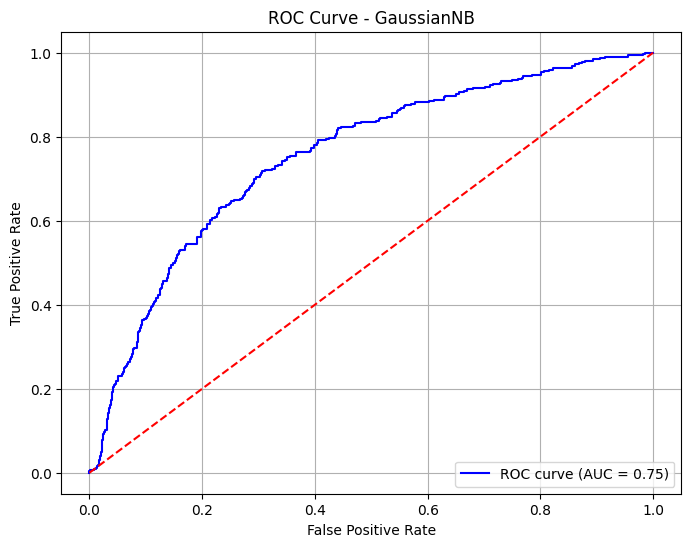

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, auc

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


y_prob = gnb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GaussianNB')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Accuracy: 0.8131
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1278
           1       0.61      0.20      0.30       322

    accuracy                           0.81      1600
   macro avg       0.72      0.58      0.60      1600
weighted avg       0.78      0.81      0.77      1600

Confusion Matrix:
[[1237   41]
 [ 258   64]]


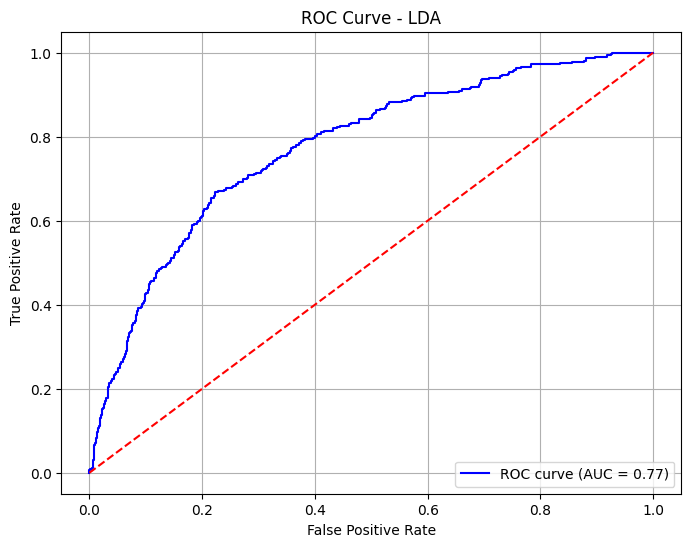

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lda)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_lda))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_lda))


y_prob_lda = lda.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LDA')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Accuracy: 0.8331
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1278
           1       0.66      0.35      0.46       322

    accuracy                           0.83      1600
   macro avg       0.76      0.65      0.68      1600
weighted avg       0.81      0.83      0.81      1600

Confusion Matrix:
[[1219   59]
 [ 208  114]]


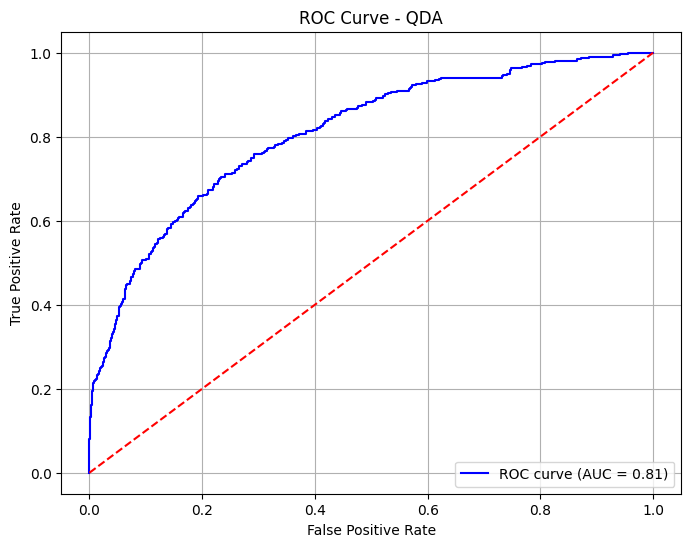

In [38]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_qda)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_qda))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_qda))


y_prob_qda = qda.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_qda)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - QDA')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy: 0.8150
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1278
           1       0.65      0.18      0.28       322

    accuracy                           0.81      1600
   macro avg       0.74      0.58      0.59      1600
weighted avg       0.79      0.81      0.77      1600

Confusion Matrix:
[[1247   31]
 [ 265   57]]


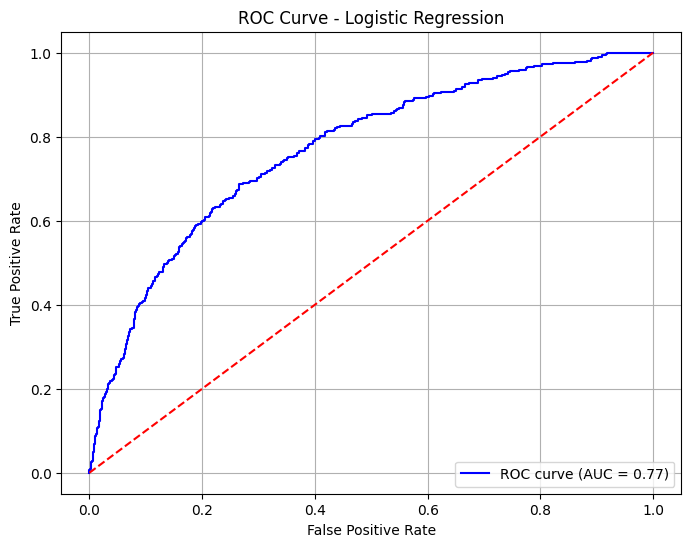

In [40]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_logreg)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_logreg))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_logreg))

y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()  


Accuracy: 0.8325
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1278
           1       0.65      0.37      0.47       322

    accuracy                           0.83      1600
   macro avg       0.75      0.66      0.69      1600
weighted avg       0.81      0.83      0.81      1600

Confusion Matrix:
[[1213   65]
 [ 203  119]]


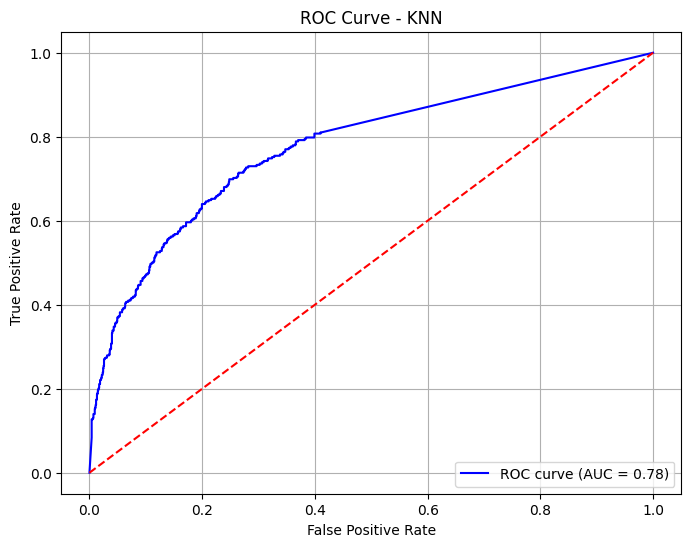

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_knn))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_knn))

y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Accuracy: 0.8569
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1278
           1       0.74      0.45      0.56       322

    accuracy                           0.86      1600
   macro avg       0.80      0.70      0.74      1600
weighted avg       0.85      0.86      0.84      1600

Confusion Matrix:
[[1226   52]
 [ 177  145]]


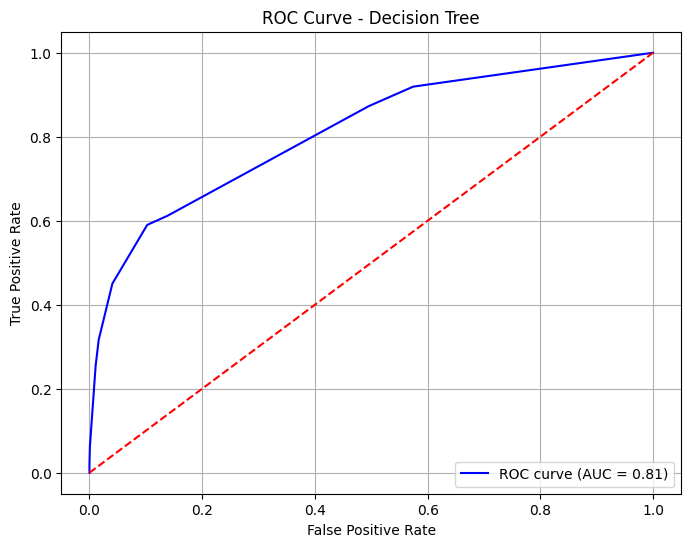

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', max_depth=20, max_leaf_nodes=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_dt))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_dt))

y_prob_dt = dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Accuracy: 0.8562
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1278
           1       0.71      0.48      0.58       322

    accuracy                           0.86      1600
   macro avg       0.79      0.72      0.74      1600
weighted avg       0.85      0.86      0.85      1600

Confusion Matrix:
[[1214   64]
 [ 166  156]]


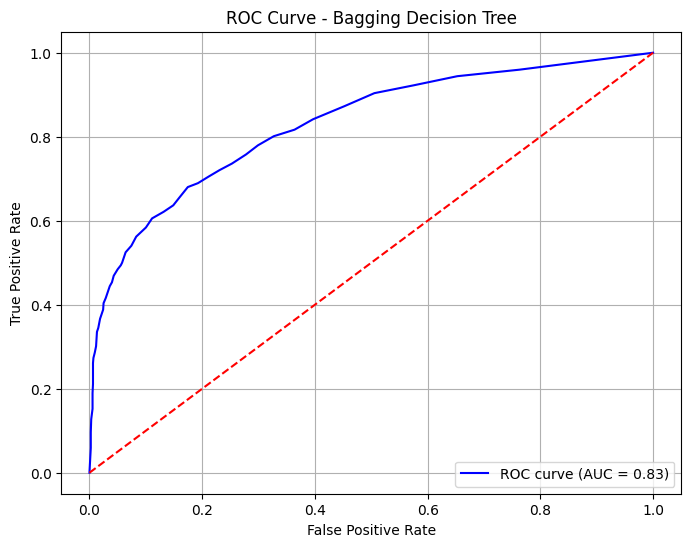

In [43]:
from sklearn.ensemble import BaggingClassifier

bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(criterion='gini', random_state=42), n_estimators=50, random_state=42)
bagging_dt.fit(X_train, y_train)
y_pred_bagging = bagging_dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_bagging)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_bagging))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_bagging))
y_prob_bagging = bagging_dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_bagging)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bagging Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Accuracy: 0.8669
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1278
           1       0.78      0.47      0.59       322

    accuracy                           0.87      1600
   macro avg       0.83      0.72      0.75      1600
weighted avg       0.86      0.87      0.85      1600

Confusion Matrix:
[[1235   43]
 [ 170  152]]


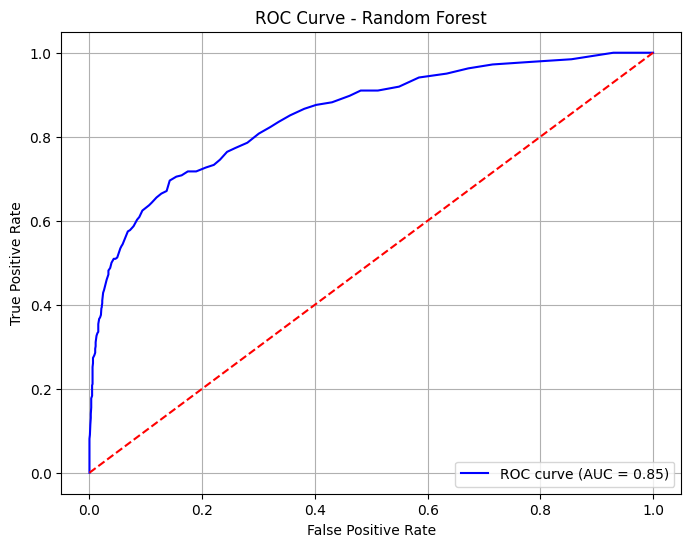

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='gini', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_rf))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))

y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Accuracy: 0.8612
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1278
           1       0.75      0.46      0.57       322

    accuracy                           0.86      1600
   macro avg       0.81      0.71      0.75      1600
weighted avg       0.85      0.86      0.85      1600

Confusion Matrix:
[[1229   49]
 [ 173  149]]


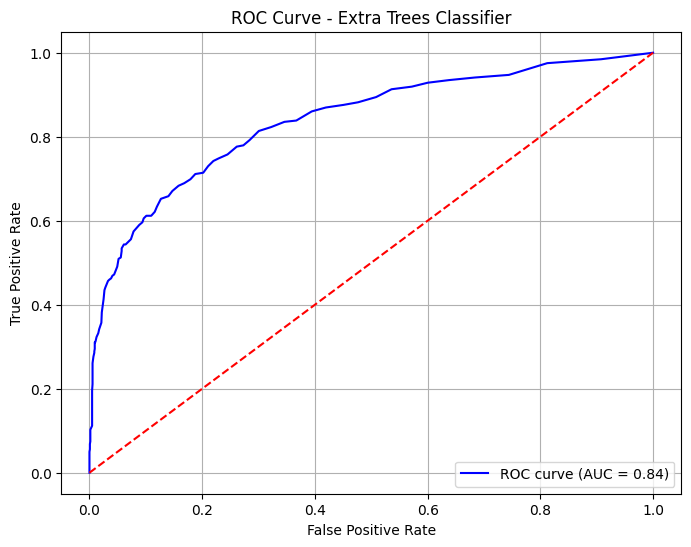

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

etf = ExtraTreesClassifier(criterion='gini', random_state=42)
etf.fit(X_train, y_train)
y_pred_etf = etf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_etf)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_etf))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_etf))

y_prob_etf = etf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_etf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Extra Trees Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Accuracy: 0.8556
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1278
           1       0.73      0.45      0.55       322

    accuracy                           0.86      1600
   macro avg       0.80      0.70      0.73      1600
weighted avg       0.84      0.86      0.84      1600

Confusion Matrix:
[[1225   53]
 [ 178  144]]


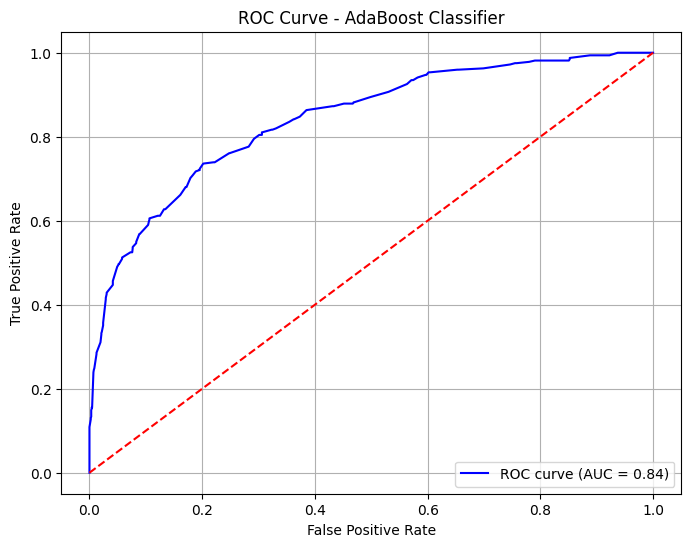

In [46]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(n_estimators=100, random_state=42)
adb.fit(X_train, y_train)
y_pred_adb = adb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_adb)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_adb))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_adb))

y_prob_adb = adb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_adb)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Accuracy: 0.8725
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1278
           1       0.80      0.49      0.61       322

    accuracy                           0.87      1600
   macro avg       0.84      0.73      0.77      1600
weighted avg       0.87      0.87      0.86      1600

Confusion Matrix:
[[1238   40]
 [ 164  158]]


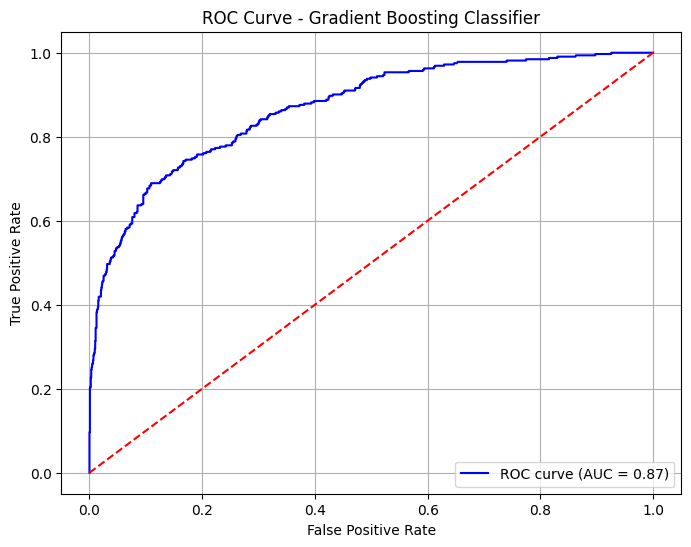

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gbc)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_gbc))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_gbc))
y_prob_gbc = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gbc)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [48]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Base learners
base_learners = [
    # Lineari / probabilistici
    ('gnb', GaussianNB()),
    ('lda', LinearDiscriminantAnalysis()),
    ('qda', QuadraticDiscriminantAnalysis()),
    ('lr', Pipeline([
        ('scaler', StandardScaler()),
        ('lr_model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])),
    
    # Alberi / ensemble
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('ab', AdaBoostClassifier(n_estimators=100, random_state=42)),
    
    # Instance-based
    ('knn', Pipeline([
        ('scaler', StandardScaler()),
        ('knn_model', KNeighborsClassifier(n_neighbors=5, weights='distance'))
    ]))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=1000)

# Stacking classifier (senza CV interna)
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=None  # niente cross-validation, usa direttamente fit sul training set
)

# Fit sul training set
stack_model.fit(X_train, y_train)

# Predizioni sul test set
y_pred = stack_model.predict(X_test)
y_prob = stack_model.predict_proba(X_test)[:, 1]

# Metriche finali
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1278
           1       0.78      0.50      0.61       322

    accuracy                           0.87      1600
   macro avg       0.83      0.73      0.77      1600
weighted avg       0.86      0.87      0.86      1600

ROC-AUC: 0.8657379056950397


In [49]:
# List of models and which X to use (scaled or not)
models_info = [
    ("GaussianNB", gnb, X_test),
    ("LDA", lda, X_test),
    ("QDA", qda, X_test),
    ("Logistic Regression", logreg, X_test_scaled),
    ("KNN", knn, X_test_scaled),
    ("Decision Tree", dt, X_test),
    ("Bagging DT", bagging_dt, X_test),
    ("Random Forest", rf, X_test),
    ("Extra Trees", etf, X_test),
    ("AdaBoost", adb, X_test),
    ("Gradient Boosting", gbc, X_test),
    ("Stacking", stack_model, X_test)
]

results = []

for name, model, X_te in models_info:
    # Predicted labels
    y_pred = model.predict(X_te)

    # Some models might not have predict_proba (just in case)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None  # or np.nan

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": roc_auc
    })

# Create summary table
summary_df = pd.DataFrame(results)
summary_df = summary_df.sort_values(by="ROC-AUC", ascending=False)

print(summary_df)


                  Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
10    Gradient Boosting  0.872500   0.797980  0.490683  0.607692  0.868712
11             Stacking  0.870625   0.777778  0.500000  0.608696  0.865738
7         Random Forest  0.866875   0.779487  0.472050  0.588008  0.851450
9              AdaBoost  0.855625   0.730964  0.447205  0.554913  0.840651
8           Extra Trees  0.861250   0.752525  0.462733  0.573077  0.838405
6            Bagging DT  0.856250   0.709091  0.484472  0.575646  0.829670
5         Decision Tree  0.856875   0.736041  0.450311  0.558767  0.810419
2                   QDA  0.833125   0.658960  0.354037  0.460606  0.809060
4                   KNN  0.832500   0.646739  0.369565  0.470356  0.776616
1                   LDA  0.813125   0.609524  0.198758  0.299766  0.774614
3   Logistic Regression  0.815000   0.647727  0.177019  0.278049  0.770466
0            GaussianNB  0.792500   0.395833  0.059006  0.102703  0.753268


In [50]:
# %% =========================
# 1) Adding anomaly features to the dataset
# ===============================

X_enhanced = X.copy()
X_enhanced['iso_anomaly'] = iso_anomaly_flag
X_enhanced['lof_anomaly'] = lof_anomaly_flag

print(X_enhanced.head())

# %% =========================
# 2) New train-test split with anomaly features
# ===============================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_anom, X_test_anom, y_train_anom, y_test_anom = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling for models that require it (logreg, KNN standalone)
scaler_anom = StandardScaler()
X_train_anom_scaled = scaler_anom.fit_transform(X_train_anom)
X_test_anom_scaled = scaler_anom.transform(X_test_anom)

# %% =========================
# 3) Re-training models with the new features
# ===============================

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Re-fit all models with the new training set (with anomaly features)

gnb_anom = GaussianNB()
gnb_anom.fit(X_train_anom, y_train_anom)

lda_anom = LinearDiscriminantAnalysis()
lda_anom.fit(X_train_anom, y_train_anom)

qda_anom = QuadraticDiscriminantAnalysis()
qda_anom.fit(X_train_anom, y_train_anom)

logreg_anom = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg_anom.fit(X_train_anom_scaled, y_train_anom)

knn_anom = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_anom.fit(X_train_anom_scaled, y_train_anom)

dt_anom = DecisionTreeClassifier(criterion='gini', max_depth=20, max_leaf_nodes=10, random_state=42)
dt_anom.fit(X_train_anom, y_train_anom)

bagging_dt_anom = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion='gini', random_state=42),
    n_estimators=50,
    random_state=42
)
bagging_dt_anom.fit(X_train_anom, y_train_anom)

rf_anom = RandomForestClassifier(criterion='gini', random_state=42)
rf_anom.fit(X_train_anom, y_train_anom)

etf_anom = ExtraTreesClassifier(criterion='gini', random_state=42)
etf_anom.fit(X_train_anom, y_train_anom)

adb_anom = AdaBoostClassifier(n_estimators=100, random_state=42)
adb_anom.fit(X_train_anom, y_train_anom)

gbc_anom = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc_anom.fit(X_train_anom, y_train_anom)

# --- Stacking with the new features ---

base_learners_anom = [
    ('gnb', GaussianNB()),
    ('lda', LinearDiscriminantAnalysis()),
    ('qda', QuadraticDiscriminantAnalysis()),
    ('lr', Pipeline([
        ('scaler', StandardScaler()),
        ('lr_model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('ab', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('knn', Pipeline([
        ('scaler', StandardScaler()),
        ('knn_model', KNeighborsClassifier(n_neighbors=5, weights='distance'))
    ]))
]

meta_learner_anom = LogisticRegression(max_iter=1000)

stack_model_anom = StackingClassifier(
    estimators=base_learners_anom,
    final_estimator=meta_learner_anom,
    cv=None
)

stack_model_anom.fit(X_train_anom, y_train_anom)

# %% =========================
# 4) New metrics table with anomaly features
# ===============================

models_info_anom = [
    ("GaussianNB", gnb_anom, X_test_anom),
    ("LDA", lda_anom, X_test_anom),
    ("QDA", qda_anom, X_test_anom),
    ("Logistic Regression", logreg_anom, X_test_anom_scaled),
    ("KNN", knn_anom, X_test_anom_scaled),
    ("Decision Tree", dt_anom, X_test_anom),
    ("Bagging DT", bagging_dt_anom, X_test_anom),
    ("Random Forest", rf_anom, X_test_anom),
    ("Extra Trees", etf_anom, X_test_anom),
    ("AdaBoost", adb_anom, X_test_anom),
    ("Gradient Boosting", gbc_anom, X_test_anom),
    ("Stacking", stack_model_anom, X_test_anom)
]

results_anom = []

for name, model, X_te in models_info_anom:
    y_pred = model.predict(X_te)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:, 1]
        roc_auc = roc_auc_score(y_test_anom, y_prob)
    else:
        roc_auc = None

    acc = accuracy_score(y_test_anom, y_pred)
    prec = precision_score(y_test_anom, y_pred)
    rec = recall_score(y_test_anom, y_pred)
    f1 = f1_score(y_test_anom, y_pred)

    results_anom.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": roc_auc
    })

summary_df_anom = pd.DataFrame(results_anom)
summary_df_anom = summary_df_anom.sort_values(by="ROC-AUC", ascending=False)

print("=== Performance with anomaly features ===")
print(summary_df_anom)

# %% =========================
# 5) Comparison before vs after (if you still have the previous summary_df)
# ===============================

try:
    comparison_df = summary_df.merge(
        summary_df_anom,
        on="Model",
        suffixes=("_base", "_anom")
    )
    print("\n=== Comparison base vs with anomalies ===")
    print(comparison_df)
except NameError:
    print("summary_df (base) is not defined in this kernel: run the cell that calculates it first.")

   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          632       0   50       5  107959.39              1          1   
1          649       0   42       7       0.00              2          0   
2          595       1   29       6  150685.79              1          1   
3          653       1   35       6  116662.96              2          1   
4          559       0   40       7  144470.77              1          1   

   IsActiveMember  Salary  Geography_Germany  Geography_Spain  iso_anomaly  \
0               1    6985               True            False            0   
1               1   22974              False            False            0   
2               0   87771              False            False            0   
3               1   23864              False             True            0   
4               1   18918              False             True            0   

   lof_anomaly  
0            0  
1            0  
2            0  
3     

Why the Anomaly Features Did Not Greatly Improve Model Performance


The anomaly features we added (iso_anomaly and lof_anomaly) are binary variables, meaning they only take values 0 or 1.
This means we are introducing only two very simple features that summarize information the models had already learned from the original dataset.
Tree-based models such as Random Forest, Gradient Boosting, Extra Trees, and AdaBoost are already very good at detecting unusual patterns, outliers, and non-linear interactions between variables. Because of this, the models were already capable of identifying customers with unusual profiles who are more likely to churn.
As a result, adding a binary feature that simply labels “this customer is unusual” does not add much new information for these models. They had already captured this pattern directly from the original variables.
Therefore:
- The models already “knew” that unusual customers tend to churn more.
- Adding a 0/1 anomaly indicator does not help them learn anything significantly new.
- This explains why the performance differences between the base models and the anomaly-augmented models are small or negligible.
- This behavior is expected and normal for powerful ensemble learners.

However, this does not mean anomaly detection is useless. It provides valuable interpretability and business insight, even if it does not dramatically change predictive accuracy.

In [ ]:
# %% =========================
# Hyperparameter tuning for key models
# ===============================

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from scipy.stats import randint, uniform

from sklearn.preprocessing import StandardScaler
scaler_tune = StandardScaler()
X_train_scaled_tune = scaler_tune.fit_transform(X_train)
X_test_scaled_tune = scaler_tune.transform(X_test)

# 1) Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)

param_dist_gb = {
    "n_estimators": randint(50, 301),        # 50–300
    "learning_rate": uniform(0.01, 0.19),    # 0.01–0.20
    "max_depth": randint(2, 6),              # 2–5
    "subsample": uniform(0.6, 0.4),          # 0.6–1.0
    "min_samples_split": randint(2, 11),     # 2–10
    "min_samples_leaf": randint(1, 11)       # 1–10
}

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist_gb,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

gb_search.fit(X_train, y_train)

print("\n=== Best Gradient Boosting params ===")
print(gb_search.best_params_)
print("Best CV ROC-AUC:", gb_search.best_score_)

gb_best = gb_search.best_estimator_
y_prob_gb_best = gb_best.predict_proba(X_test)[:, 1]
y_pred_gb_best = gb_best.predict(X_test)

print("\n=== Gradient Boosting tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_gb_best))
print("Precision:", precision_score(y_test, y_pred_gb_best))
print("Recall:", recall_score(y_test, y_pred_gb_best))
print("F1-score:", f1_score(y_test, y_pred_gb_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_gb_best))


# 2) Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist_rf = {
    "n_estimators": randint(100, 401),       # 100–400
    "max_depth": [None] + list(range(3, 11)),# None + 3–10
    "min_samples_split": randint(2, 21),     # 2–20
    "min_samples_leaf": randint(1, 21),      # 1–20
    "max_features": ["sqrt", "log2", 0.5, 0.7, None],
    "class_weight": [None, "balanced", "balanced_subsample"]
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=40,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

print("\n=== Best Random Forest params ===")
print(rf_search.best_params_)
print("Best CV ROC-AUC:", rf_search.best_score_)

rf_best = rf_search.best_estimator_
y_prob_rf_best = rf_best.predict_proba(X_test)[:, 1]
y_pred_rf_best = rf_best.predict(X_test)

print("\n=== Random Forest tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_best))
print("Precision:", precision_score(y_test, y_pred_rf_best))
print("Recall:", recall_score(y_test, y_pred_rf_best))
print("F1-score:", f1_score(y_test, y_pred_rf_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf_best))


# 3) Logistic Regression (con scaling)
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=500,
    solver="liblinear",      # robusto per C + class_weight
    class_weight="balanced"
)

param_dist_lr = {
    "C": uniform(0.01, 9.99),        # 0.01–10
    "penalty": ["l1", "l2"]
}

lr_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist_lr,
    n_iter=30,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lr_search.fit(X_train_scaled_tune, y_train)

print("\n=== Best Logistic Regression params ===")
print(lr_search.best_params_)
print("Best CV ROC-AUC:", lr_search.best_score_)

lr_best = lr_search.best_estimator_
y_prob_lr_best = lr_best.predict_proba(X_test_scaled_tune)[:, 1]
y_pred_lr_best = lr_best.predict(X_test_scaled_tune)

print("\n=== Logistic Regression tuned - Test metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_best))
print("Precision:", precision_score(y_test, y_pred_lr_best))
print("Recall:", recall_score(y_test, y_pred_lr_best))
print("F1-score:", f1_score(y_test, y_pred_lr_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr_best))


Fitting 5 folds for each of 40 candidates, totalling 200 fits

=== Best Gradient Boosting params ===
{'learning_rate': np.float64(0.028995234005420548), 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 149, 'subsample': np.float64(0.6571467271687763)}
Best CV ROC-AUC: 0.8650538479448905

=== Gradient Boosting tuned - Test metrics ===
Accuracy: 0.868125
Precision: 0.7905759162303665
Recall: 0.468944099378882
F1-score: 0.5886939571150097
ROC-AUC: 0.8651692765287377
Fitting 5 folds for each of 40 candidates, totalling 200 fits

=== Best Random Forest params ===
{'class_weight': 'balanced_subsample', 'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 151}
Best CV ROC-AUC: 0.8616548822193819

=== Random Forest tuned - Test metrics ===
Accuracy: 0.825625
Precision: 0.5530864197530864
Recall: 0.6956521739130435
F1-score: 0.6162310866574966
ROC-AUC: 0.8576580254473702
Fitting 5 folds for each of 30 candidates, tota